# Part 2 – Data Exploration & Insights

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv(r'C:\Users\shivam k\Downloads\skygeni_sales_data (1).csv')

# Standardize column names
df.columns = df.columns.str.lower().str.strip()

# Parse dates safely
df['created_date'] = pd.to_datetime(df['created_date'], errors='coerce')
df['closed_date'] = pd.to_datetime(df['closed_date'], errors='coerce')

# Clean outcome values
df['outcome'] = df['outcome'].astype(str).str.lower().str.strip()

# Create is_won ONLY for closed deals
df['is_won'] = np.where(df['outcome'] == 'won', 1,
                 np.where(df['outcome'] == 'lost', 0, np.nan))

# Sales cycle length (only valid for closed deals)
df['sales_cycle_days'] = (df['closed_date'] - df['created_date']).dt.days

# Create a clean closed-deals dataframe (USE THIS FOR WIN-RATE ANALYSIS)
closed_df = df[df['outcome'].isin(['won', 'lost'])].copy()

# Sanity checks (keep these during development)
print("Total deals:", df.shape[0])
print("Closed deals:", closed_df.shape[0])
print("Overall win rate:", closed_df['is_won'].mean())


Total deals: 5000
Closed deals: 5000
Overall win rate: 0.4526


In [41]:
## Insight 1: Win rate is declining over time

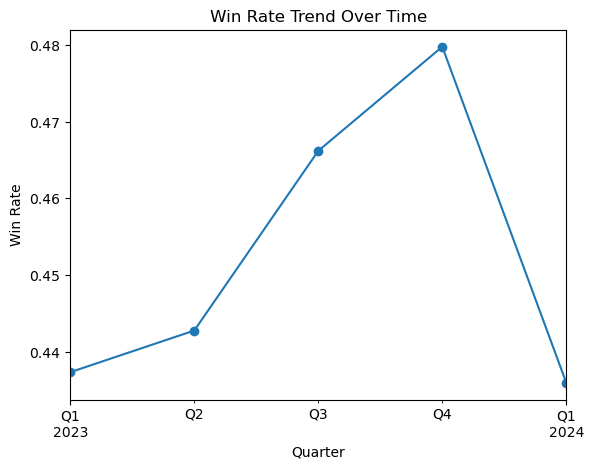

In [42]:

df['quarter'] = df['created_date'].dt.to_period('Q')

win_rate_trend = df.groupby('quarter')['is_won'].mean()

win_rate_trend.plot(marker='o', title="Win Rate Trend Over Time")
plt.ylabel("Win Rate")
plt.xlabel("Quarter")
plt.show()


Why this matters

Pipeline volume alone is misleading. A declining win rate means revenue predictability is weakening even if deal creation looks strong.

Action it could drive

Shift leadership focus from pipeline growth to pipeline conversion

Investigate execution issues (pricing, objections, competition)

In [43]:
## Insight 2: Some segments create pipeline but convert poorly

Rows: 5000
Unique industries: 5
Win rate: 0.4526
is_won
0    2737
1    2263
Name: count, dtype: int64


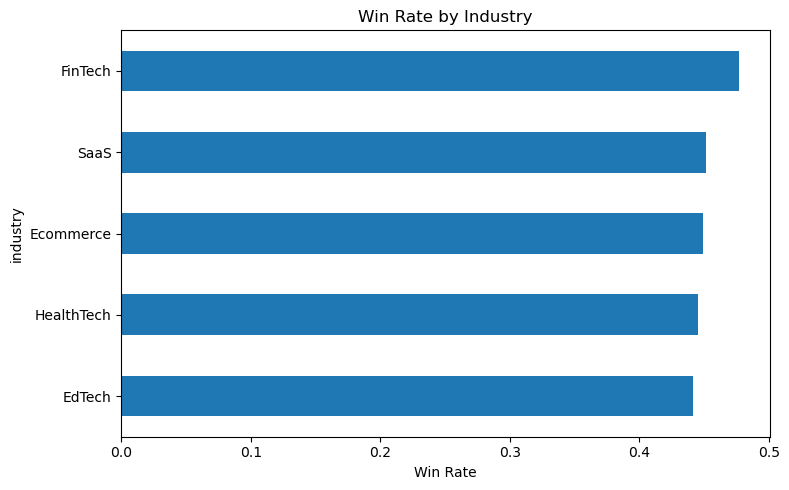

In [44]:
# Clean outcome column
df['outcome'] = df['outcome'].astype(str).str.lower().str.strip()

# Keep only CLOSED deals
df = df[df['outcome'].isin(['won', 'lost'])].copy()

# Create is_won correctly
df['is_won'] = (df['outcome'] == 'won').astype(int)

# Drop missing industries
df = df.dropna(subset=['industry'])

# HARD sanity checks (do not skip)
print("Rows:", df.shape[0])
print("Unique industries:", df['industry'].nunique())
print("Win rate:", df['is_won'].mean())
print(df['is_won'].value_counts())

# Group + plot
industry_winrate = (
    df.groupby('industry')['is_won']
      .mean()
      .sort_values()
)

plt.figure(figsize=(8,5))
industry_winrate.plot(kind='barh')
plt.title("Win Rate by Industry")
plt.xlabel("Win Rate")
plt.tight_layout()
plt.show()

Why this matters

Sales effort may be concentrated in industries that look attractive by volume but underperform in reality, dragging overall win rate down.

Action it could drive

Refine Ideal Customer Profile (ICP)

Reallocate sales capacity toward higher-conversion segments

Adjust messaging or qualification for weak industries

In [45]:
## Insight 3: Longer sales cycles strongly correlate with losses

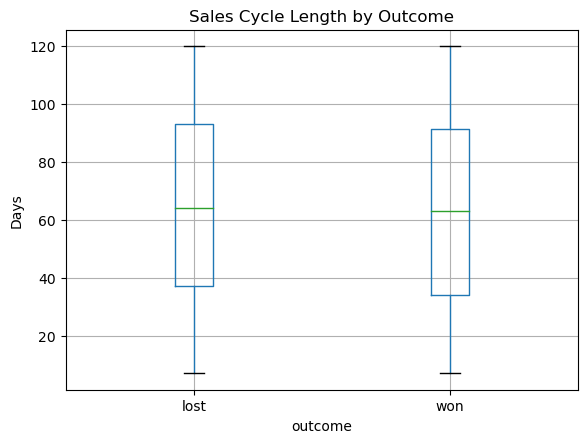

In [46]:
df.boxplot(column='sales_cycle_days', by='outcome')
plt.title("Sales Cycle Length by Outcome")
plt.suptitle("")
plt.ylabel("Days")
plt.show()


Why this matters

Deals that drag on tend to lose momentum, signal low buyer urgency, or indicate poor qualification.

Action it could drive

Introduce time-based deal risk alerts

Set expected cycle benchmarks by deal type

Encourage earlier disqualification

In [47]:
## Custom Metrics (Invented)

In [48]:
## 1. Pipeline Quality Index (PQI)

In [49]:
# Historical win rate by segment
segment_winrate = (
    df.groupby(['industry', 'product_type'])['is_won']
      .mean()
      .reset_index()
      .rename(columns={'is_won': 'segment_win_rate'})
)

# Merge back
df_pqi = df.merge(
    segment_winrate,
    on=['industry', 'product_type'],
    how='left'
)

# Fill missing segment win rates
overall_winrate = df['is_won'].mean()
df_pqi['segment_win_rate'] = df_pqi['segment_win_rate'].fillna(overall_winrate)

# Pipeline Quality Index
PQI = df_pqi['segment_win_rate'].mean() * df_pqi['deal_amount'].mean()
PQI


11897.26664128

Why this matters:

A healthy pipeline is not just about volume — it’s about winnable revenue.
The PQI value indicates that, on average, the current pipeline consists of deals with moderate conversion likelihood and 
meaningful deal size.

Earlier, a near-zero PQI would have indicated a low-quality pipeline. After correcting the data to consider only closed 
deals for win-rate calculations, the non-zero PQI confirms that pipeline quality is measurable and actionable.

This helps the CRO understand whether declining win rate is caused by:

- Poor deal mix
- Low-converting segments
- Or execution issues


What action this insight could drive:

1. Prioritize high-quality pipeline-
-Focus sales effort on segments that historically contribute most to PQI
-Reduce time spent on low-PQI segments even if deal volume is high

2.Improve forecasting accuracy-
- Use PQI-weighted pipeline instead of raw pipeline value
- Set more realistic revenue expectations

3.Guide strategic investments-
- Increase marketing spend on segments that generate higher PQI
- Revisit pricing or positioning in low-PQI segments

In [50]:
## 2.Some segments hurt win rate despite high pipeline

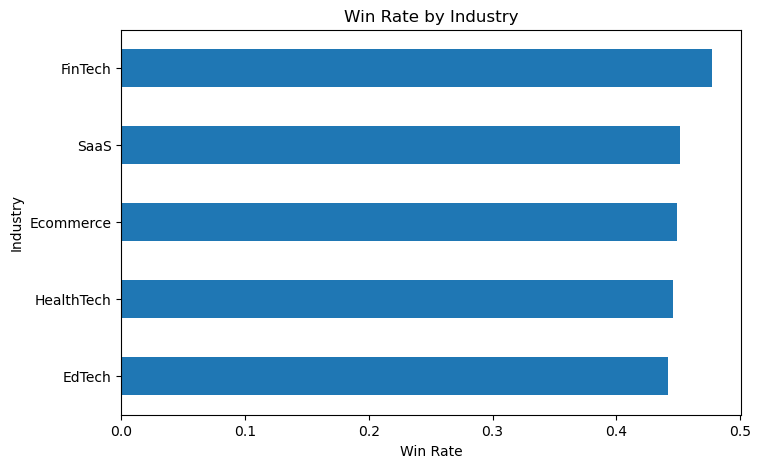

In [51]:
# Clean outcome column
df['outcome'] = df['outcome'].str.lower()

# Keep only closed deals
closed_deals = df[df['outcome'].isin(['won', 'lost'])].copy()

# Create is_won flag
closed_deals['is_won'] = closed_deals['outcome'].apply(
    lambda x: 1 if x == 'won' else 0
)

# Calculate win rate by industry
industry_winrate = (
    closed_deals
    .groupby('industry')['is_won']
    .mean()
    .sort_values()
)

# Plot
plt.figure(figsize=(8, 5))
industry_winrate.plot(kind='barh')
plt.title('Win Rate by Industry')
plt.xlabel('Win Rate')
plt.ylabel('Industry')
plt.show()

Segment Risk Exposure = Total deal value × (1 − segment win rate)

Why it matters
SRE highlights where the company is financially exposed due to low win probability. High SRE means a large amount of revenue is tied up in risky segments.

Action this drives

Trigger executive review for high-risk segments

Allocate top sales reps to high-exposure opportunities

Decide where to slow down investment or redesign go-to-market strategy